In [1]:
# This Python 3 environment comes with many helpful analytics libraries ins mandeep kharb
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import numpy as np
import os
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
dataset_path = '../dataset/dataset_blood_group'

In [8]:
BATCH_SIZE = 32

In [9]:
# Step 1: Load dataset
dataset = image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(64, 64), # Resize images to a standard size
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 8000 files belonging to 8 classes.


In [29]:
# Step 2: Check class distribution
class_names = dataset.class_names
class_counts = Counter()

for _, labels in dataset.unbatch():
    class_counts[int(labels.numpy())] += 1

print("Class Distribution:")
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count}")

Class Distribution:
B-: 1000
A+: 1000
B+: 1000
O+: 1000
AB-: 1000
O-: 1000
AB+: 1000
A-: 1000


In [32]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_names, class_counts):
    """
    Plots the distribution of classes in the dataset.

    Parameters:
    class_names (list): List of class names.
    class_counts (dict): Dictionary with class indices as keys and counts as values.

    Returns:
    None
    """

    # Extract class names and their corresponding counts
    classes = [class_names[i] for i in class_counts.keys()]
    counts = [class_counts[i] for i in class_counts.keys()]
    
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Classes in the Dataset')
    plt.xticks(rotation=45)

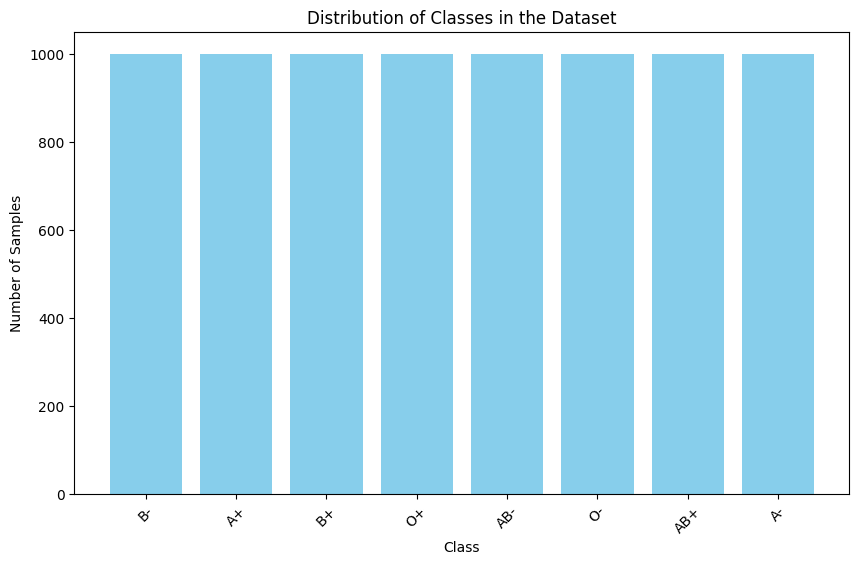

In [33]:
# Assuming class_names and class_counts are already calculated
plot_class_distribution(class_names, class_counts)

In [34]:
max_count = max(class_counts.values())

In [35]:
# Function to oversample a class
def oversample_class(class_id, count, max_count):
    # Ensure the dataset is unbatched for filtering
    unbatched_dataset = dataset.unbatch()

    # Filter the dataset for the specific class
    class_dataset = unbatched_dataset.filter(lambda img, lbl: tf.equal(lbl, class_id))

    # Calculate the number of repetitions needed
    repeat_factor = max_count // count + (max_count % count > 0)

    # Repeat the dataset to match the desired count
    return class_dataset.repeat(repeat_factor).take(max_count)

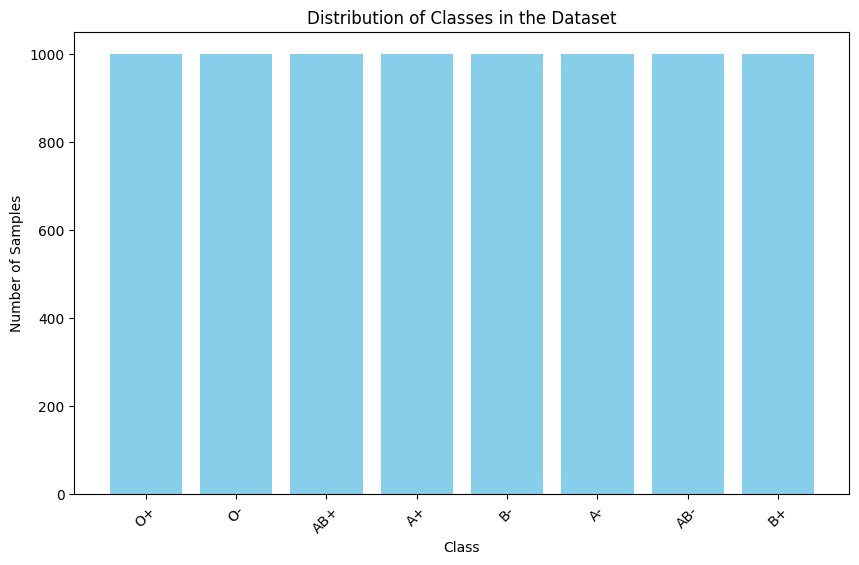

In [36]:
# Step 1: Balance the dataset
balanced_datasets = []
for class_id, count in class_counts.items():
    balanced_datasets.append(oversample_class(class_id, count, max_count))

# Step 2: Combine balanced datasets
balanced_dataset = tf.data.Dataset.sample_from_datasets(balanced_datasets)

# Step 3: Check balanced class distribution
balanced_class_counts = Counter([int(lbl.numpy()) for _, lbl in balanced_dataset])
plot_class_distribution(class_names, balanced_class_counts)

# Step 4: Batch the balanced dataset
balanced_dataset = balanced_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [37]:
for sample in balanced_dataset.take(10):
    print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [39]:
balanced_dataset_unbatched = balanced_dataset.unbatch()
dataset_size = sum(1 for _ in balanced_dataset_unbatched)

print(f"Total dataset size: {dataset_size}")

Total dataset size: 8000


In [41]:
#Define train,validation and test ratio
train_ratio = 0.7
val_ratio = 0.2
# Unbatch the dataset to work at the sample level
balanced_dataset_unbatched = balanced_dataset.unbatch()

# Compute sizes based on dataset size and desired splits
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)

# Split the dataset into training, validation, and test
train_dataset = balanced_dataset_unbatched.take(train_size)
val_test_dataset = balanced_dataset_unbatched.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

# Rebatch the datasets after splitting
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
# Check the number of batches in each dataset
train_batch_count = sum(1 for _ in train_dataset)
val_batch_count = sum(1 for _ in val_dataset)
test_batch_count = sum(1 for _ in test_dataset)

print(f"Training dataset size: {train_batch_count * BATCH_SIZE}")
print(f"Validation dataset size: {val_batch_count * BATCH_SIZE}")
print(f"Testing dataset size: {test_batch_count * BATCH_SIZE}")

Training dataset size: 5600
Validation dataset size: 1600
Testing dataset size: 800


In [44]:
import tensorflow as tf

def create_high_accuracy_model(class_names):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(64, 64, 3)),  # Define the input shape directly with Input layer
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Example usage assuming class_names is defined
# class_names = ['class1', 'class2', ...] # Define your class names based on your dataset
high_acc_model = create_high_accuracy_model(class_names)

In [45]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define ReduceLROnPlateau callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',        # Monitor validation loss
    factor=0.5,                # Reduce the learning rate by a factor of 0.5
    patience=3,                # Wait for 3 epochs without improvement before reducing LR
    verbose=1,                 # Print a message when the learning rate is reduced
    min_lr=1e-6               # Minimum learning rate to avoid too small values
)

# Define EarlyStopping callback to stop training when validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=5,                # Stop after 5 epochs without improvement
    verbose=1,                 # Print a message when training is stopped
    restore_best_weights=True   # Restore the model weights from the best epoch
)

In [46]:
# Train the model

history_high_acc = high_acc_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,  # Adjust the number of epochs based on your preference
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/50
    175/Unknown 16s 88ms/step - accuracy: 0.1283 - loss: 41.6276 

/Users/thousifahamed/Desktop/BloodGroupDetectionUsingFingerprint/venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - accuracy: 0.1283 - loss: 41.4532 - val_accuracy: 0.1262 - val_loss: 2.0381 - learning_rate: 0.0010
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.1864 - loss: 2.0248 - val_accuracy: 0.1262 - val_loss: 2.0367 - learning_rate: 0.0010
Epoch 3/50
  1/175 ━━━━━━━━━━━━━━━━━━━━ 27s 160ms/step - accuracy: 0.1562 - loss: 1.8812

2025-02-15 15:51:28.117740: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.3356 - loss: 1.7194 - val_accuracy: 0.1477 - val_loss: 1.9661 - learning_rate: 0.0010
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.4518 - loss: 1.4375 - val_accuracy: 0.3241 - val_loss: 1.7446 - learning_rate: 0.0010
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.5309 - loss: 1.2546 - val_accuracy: 0.4301 - val_loss: 1.5185 - learning_rate: 0.0010
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.5495 - loss: 1.1946 - val_accuracy: 0.4099 - val_loss: 1.4833 - learning_rate: 0.0010
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.5925 - loss: 1.0806 - val_accuracy: 0.6489 - val_loss: 1.1942 - learning_rate: 0.0010
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.6158 - loss: 1.0361 - val_accuracy: 0.6955 - val_loss: 1.1043 - learning_rate: 0.0010
Epoch 9/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.6538 - loss:

2025-02-15 15:53:58.147053: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.6827 - loss: 0.8420 - val_accuracy: 0.7249 - val_loss: 0.9834 - learning_rate: 0.0010
Epoch 12/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.7043 - loss: 0.8039 - val_accuracy: 0.7384 - val_loss: 0.8887 - learning_rate: 0.0010
Epoch 13/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.7081 - loss: 0.7883 - val_accuracy: 0.7561 - val_loss: 0.8229 - learning_rate: 0.0010
Epoch 14/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.7148 - loss: 0.7716 - val_accuracy: 0.6789 - val_loss: 0.9842 - learning_rate: 0.0010
Epoch 15/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.7303 - loss: 0.7508 - val_accuracy: 0.7598 - val_loss: 0.8221 - learning_rate: 0.0010
Epoch 16/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.7256 - loss: 0.7419 - val_accuracy: 0.7525 - val_loss: 0.8507 - learning_rate: 0.0010
Epoch 17/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.7099 -

2025-02-15 15:59:17.578465: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.7934 - loss: 0.5452 - val_accuracy: 0.8241 - val_loss: 0.5349 - learning_rate: 5.0000e-04
Epoch 28/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.7982 - loss: 0.5232 - val_accuracy: 0.8241 - val_loss: 0.5427 - learning_rate: 5.0000e-04
Epoch 29/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.8112 - loss: 0.5154 - val_accuracy: 0.8015 - val_loss: 0.6189 - learning_rate: 5.0000e-04
Epoch 30/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8066 - loss: 0.5194 
Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.8066 - loss: 0.5194 - val_accuracy: 0.8272 - val_loss: 0.5755 - learning_rate: 5.0000e-04
Epoch 31/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.8102 - loss: 0.5035 - val_accuracy: 0.8388 - val_loss: 0.5083 - learning_rate: 2.5000e-04
Epoch 32/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step -

In [47]:
# Evaluate the model on validation data
high_acc_eval = high_acc_model.evaluate(val_dataset)

print(f"High Accuracy Model Loss: {high_acc_eval[0]}, Accuracy: {high_acc_eval[1]}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8850 - loss: 0.3838
High Accuracy Model Loss: 0.39456707239151, Accuracy: 0.8658088445663452


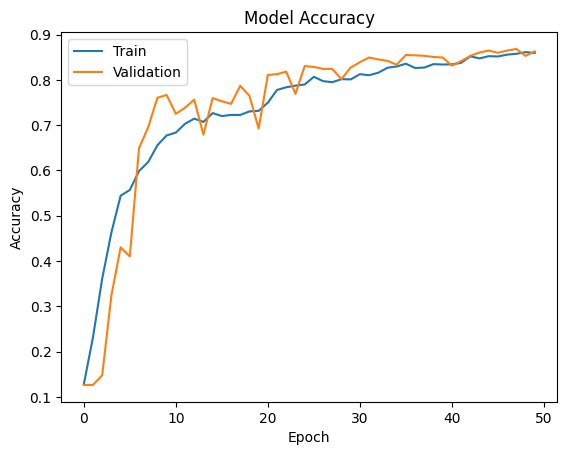

In [48]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Call the function to display the accuracy graph
plot_accuracy(history_high_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Classification Report:
              precision    

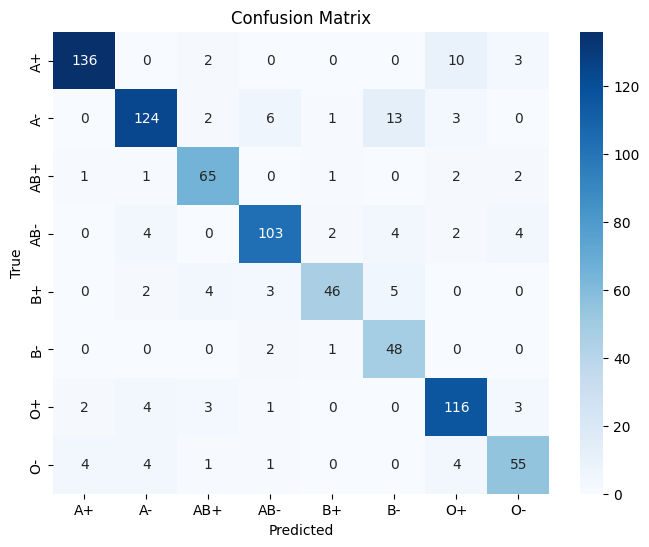

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# Get predictions on the test dataset
y_true = []  # True labels
y_pred = []  # Predicted labels

# Iterate over the test dataset and collect the true and predicted labels
for images, labels in test_dataset:
    predictions = high_acc_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert softmax to class labels
    y_true.extend(labels.numpy())  # Convert tensor to numpy array and append
    y_pred.extend(predicted_labels)  # Append the predicted labels

y_true = np.array(y_true)  # Convert list to numpy array for processing
y_pred = np.array(y_pred)  # Convert list to numpy array for processing

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [51]:
high_acc_model.save('model.h5') # The model will be saved as 'my_model.h5'
print("Model saved as HDF5 format.")

# Model saved as HDF5 format.

Model saved as HDF5 format.


In [52]:
pip show pillow

Name: pillow
Version: 11.1.0
Summary: Python Imaging Library (Fork)
Home-page: https://python-pillow.github.io
Author: 
Author-email: "Jeffrey A. Clark" <aclark@aclark.net>
License: MIT-CMU
Location: /Users/thousifahamed/Desktop/BloodGroupDetectionUsingFingerprint/venv/lib/python3.12/site-packages
Requires: 
Required-by: matplotlib
Note: you may need to restart the kernel to use updated packages.
